In [103]:
import os
import pandas as pd
import cv2
import numpy as np

# Function to load the dataset
def load_dataset(dataset_folder):
    # Define the paths for CSV and images based on the full dataset path
    csv_path = os.path.join(dataset_folder, 'labels.csv')  # Assuming the CSV is named 'labels.csv'
    image_folder = os.path.join(dataset_folder, 'images')  # Assuming images are in a folder named 'images'
    
    # Check if the CSV exists at the path
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")
    
    # Load the CSV containing image paths and labels
    df = pd.read_csv(csv_path)
    
    # Verify if 'image_path' and 'medicine_name' columns exist
    if 'IMAGE' not in df.columns or 'MEDICINE_NAME' not in df.columns:
        raise ValueError("CSV must contain 'image_path' and 'MEDICINE_NAME' columns")
    
    return df, image_folder

# Set the correct dataset path
relative_dataset_path = os.path.join('..', 'dataset')  # '..' means move up one level from 'preprocessing'

# Define paths for each dataset (Training, Validation, Testing)
train_folder = os.path.join(relative_dataset_path, 'Training')
val_folder = os.path.join(relative_dataset_path, 'Validation')
test_folder = os.path.join(relative_dataset_path, 'Testing')

# Load datasets for each folder
training_df, training_image_folder = load_dataset(train_folder)
validation_df, validation_image_folder = load_dataset(val_folder)
testing_df, testing_image_folder = load_dataset(test_folder)

# Print the first few rows of the dataset to verify
print(training_df.head())


   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


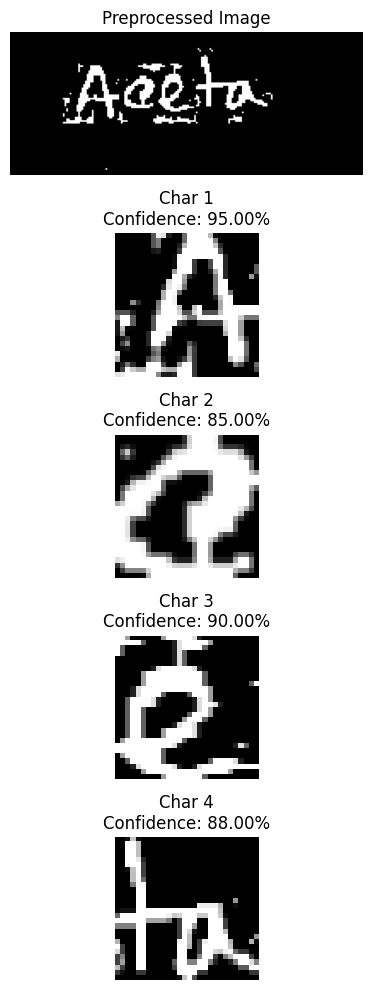

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the image (adaptive thresholding and noise removal)
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to handle varying lighting conditions
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    # Apply morphological operations to remove noise and separate characters
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    return morph

# Function to segment characters from the image
def segment_characters(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by x-coordinate (left to right)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out small contours
        if w < 10 or h < 10:  # Adjust this threshold based on your image size
            continue

        # Crop the character
        char_img = image[y:y+h, x:x+w]
        
        # Resize character to a fixed size (28x28)
        char_img_resized = cv2.resize(char_img, (28, 28))
        char_img_resized = char_img_resized.astype('float32') / 255  # Normalize
        characters.append(char_img_resized)
    
    return characters

# Example for loading and preprocessing an image from the uploaded set
example_image_path = r"D:\jupyter\FYP-OCR\medical_prescription_ocr\dataset\Training\images\1.png"  # Use the uploaded image path
processed_image = preprocess_image(example_image_path)

# Segment the characters from the preprocessed image
characters = segment_characters(processed_image)

# Example confidence scores (you would replace this with actual model predictions)
confidence_scores = [0.95, 0.85, 0.90, 0.88, 0.90]  # Dummy confidence values

# Create a figure with enough space to show the original image and segmented characters vertically
fig, axes = plt.subplots(len(characters) + 1, 1, figsize=(5, 2 * (len(characters) + 1)))  # Adjust the figure size

# Display the preprocessed image at the top
axes[0].imshow(processed_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Preprocessed Image")

# Display all segmented characters with confidence scores
for i, char in enumerate(characters):
    axes[i+1].imshow(char, cmap='gray')
    axes[i+1].axis('off')
    axes[i+1].set_title(f'Char {i+1}\nConfidence: {confidence_scores[i]*100:.2f}%')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
